
# AI.3 - Breast Cancer Diagnosis with Multi-Modal Imaging
## Baseline CNN Implementation for Lesion Segmentation
This notebook implements a U-Net based CNN for segmenting breast cancer lesions from multi-modal imaging data (MRI, Ultrasound, Mammography).


### Project Overview:
 - **Objective**: Train a CNN to segment potential cancerous lesions in breast tissue
 - **Architecture**: U-Net with encoder-decoder structure
 - **Dataset**: Kaggle Breast Cancer MSI Multimodal Dataset
 - **Output**: Binary segmentation masks for lesion detection


## 0. Setup and Imports

In [1]:
!pip install torch torchvision opencv-python albumentations matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# Core libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF

# Data processing
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

# Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🖥️ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")

✅ All libraries imported successfully!
🔥 PyTorch version: 2.1.0+cu118
🖥️ CUDA available: True
🎮 GPU: NVIDIA A30


## 1. Download and Verify Dataset

In [3]:
import shutil
import os

# Source (where KaggleHub stored the dataset)
src_path = "/home/omniflow/.cache/kagglehub/datasets/zoya77/breast-cancer-msi-multimodal-image-dataset/versions/1"

# Destination (your current project /data folder)
dst_path = os.path.join(os.getcwd(), "data")

# Copy dataset into /data (use move if you don’t want to keep original)
shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

print("Dataset is now available at:", dst_path)

Dataset is now available at: /home/omniflow/test/data


In [4]:
!ls -d /home/omniflow/test/data/*/*/*/

 /home/omniflow/test/data/Chest_XRay_MSI/Test/Malignant/
 /home/omniflow/test/data/Chest_XRay_MSI/Test/Normal/
 /home/omniflow/test/data/Chest_XRay_MSI/Train/Malignant/
 /home/omniflow/test/data/Chest_XRay_MSI/Train/Normal/
 /home/omniflow/test/data/Chest_XRay_MSI/Val/Malignant/
 /home/omniflow/test/data/Chest_XRay_MSI/Val/Normal/
 /home/omniflow/test/data/Histopathological_MSI/Test/benign/
 /home/omniflow/test/data/Histopathological_MSI/Test/malignant/
 /home/omniflow/test/data/Histopathological_MSI/Train/benign/
 /home/omniflow/test/data/Histopathological_MSI/Train/malignant/
 /home/omniflow/test/data/Histopathological_MSI/Val/benign/
 /home/omniflow/test/data/Histopathological_MSI/Val/malignant/
'/home/omniflow/test/data/MultiModel Breast Cancer MSI Dataset/Chest_XRay_MSI/Malignant/'
'/home/omniflow/test/data/MultiModel Breast Cancer MSI Dataset/Chest_XRay_MSI/Normal/'
'/home/omniflow/test/data/MultiModel Breast Cancer MSI Dataset/Histopathological_MSI/benign/'
'/home/omniflow/test/

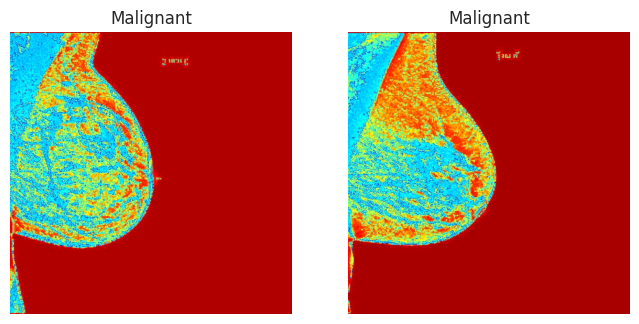

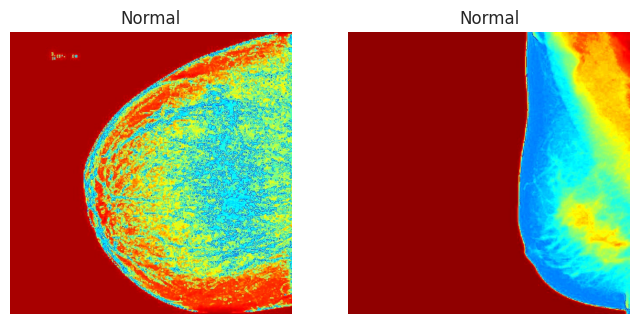

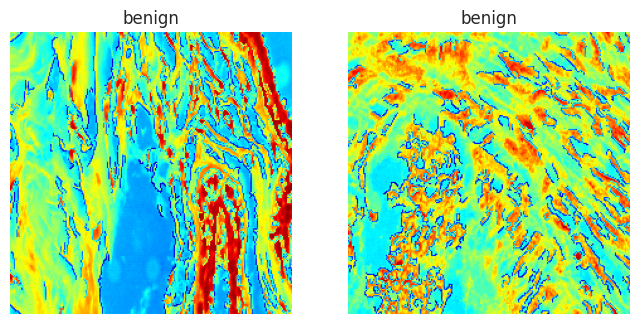

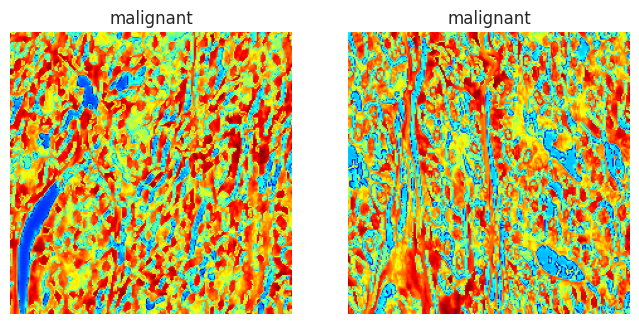

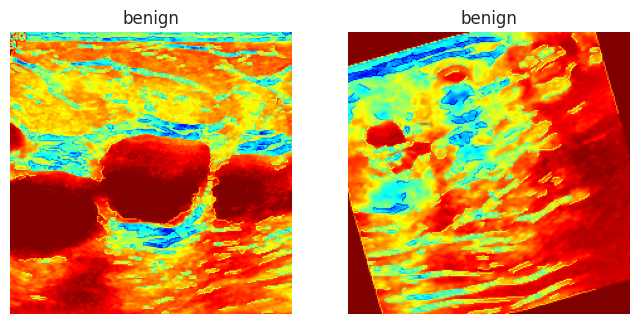

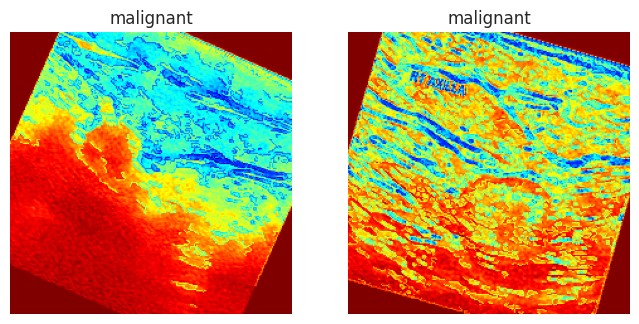

In [5]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Paths to each modality/class
folders = [
    '/home/omniflow/test/data/MultiModel Breast Cancer MSI Dataset/Chest_XRay_MSI/Malignant/',
    '/home/omniflow/test/data/MultiModel Breast Cancer MSI Dataset/Chest_XRay_MSI/Normal/',
    '/home/omniflow/test/data/MultiModel Breast Cancer MSI Dataset/Histopathological_MSI/benign/',
    '/home/omniflow/test/data/MultiModel Breast Cancer MSI Dataset/Histopathological_MSI/malignant/',
    '/home/omniflow/test/data/MultiModel Breast Cancer MSI Dataset/Ultrasound Images_MSI/benign/',
    '/home/omniflow/test/data/MultiModel Breast Cancer MSI Dataset/Ultrasound Images_MSI/malignant/',
]

# Visualize 2 random images from each folder
for folder in folders:
    label = os.path.basename(folder.rstrip("/"))
    images = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if len(images) == 0:
        print(f"No images found in {folder}")
        continue
    
    sample_images = random.sample(images, min(2, len(images)))
    
    plt.figure(figsize=(8, 4))
    for i, img_path in enumerate(sample_images, 1):
        img = Image.open(img_path)
        plt.subplot(1, 2, i)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()

In [6]:
import os
import shutil
import random

def split_dataset(source_dir, train_dir, val_dir, test_dir, val_ratio=0.1, test_ratio=0.1, seed=42):
    random.seed(seed)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path)
                  if f.lower().endswith(('.png','.jpg','.jpeg','.bmp','.tif'))]
        random.shuffle(images)

        n_total = len(images)
        n_test = int(n_total * test_ratio)
        n_val = int(n_total * val_ratio)
        n_train = n_total - n_val - n_test

        # Create destination class folders
        for folder in [train_dir, val_dir, test_dir]:
            os.makedirs(os.path.join(folder, class_name), exist_ok=True)

        # Copy images
        for img in images[:n_train]:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in images[n_train:n_train+n_val]:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))
        for img in images[n_train+n_val:]:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

modalities = ["Ultrasound Images_MSI", "Histopathological_MSI", "Chest_XRay_MSI"]

for modality in modalities:
    source = f"data/MultiModel Breast Cancer MSI Dataset/{modality}"      # your current folder with benign/malignant
    train_dest = f"data/{modality}/Train"
    val_dest = f"data/{modality}/Val"
    test_dest = f"data/{modality}/Test"

    split_dataset(source, train_dest, val_dest, test_dest, val_ratio=0.1, test_ratio=0.1)

In [37]:
class ClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        classes = sorted(os.listdir(root_dir))  # e.g., ['benign', 'malignant']
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

        for cls_name in classes:
            cls_path = os.path.join(root_dir, cls_name)
            for f in os.listdir(cls_path):
                if f.lower().endswith(('.png','.jpg','.jpeg')):
                    self.image_paths.append(os.path.join(cls_path, f))
                    self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [29]:
modalities = {
    "Ultrasound Images_MSI": {
        "train": "data/Ultrasound Images_MSI/Train",
        "val": "data/Ultrasound Images_MSI/Val"
    },
    "Histopathological_MSI": {
        "train": "data/Histopathological_MSI/Train",
        "val": "data/Histopathological_MSI/Val"
    },
    "Chest_XRay_MSI": {
        "train": "data/Chest_XRay_MSI/Train",
        "val": "data/Chest_XRay_MSI/Val"
    }
}


train_modalities_paths = {
    "Chest_XRay_MSI": modalities["Chest_XRay_MSI"]["train"],
    "Histopathological_MSI": modalities["Histopathological_MSI"]["train"],
    "Ultrasound Images_MSI": modalities["Ultrasound Images_MSI"]["train"]
}

val_modalities_paths = {
    "Chest_XRay_MSI": modalities["Chest_XRay_MSI"]["val"],
    "Histopathological_MSI": modalities["Histopathological_MSI"]["val"],
    "Ultrasound Images_MSI": modalities["Ultrasound Images_MSI"]["val"]
}

In [45]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Use ClassificationDataset, not SingleModalityDataset
ultrasound_train = ClassificationDataset("data/Ultrasound Images_MSI/Train", transform=train_transform)
ultrasound_val   = ClassificationDataset("data/Ultrasound Images_MSI/Val", transform=val_transform)

ultrasound_loader = DataLoader(ultrasound_train, batch_size=8, shuffle=True)
ultrasound_val_loader = DataLoader(ultrasound_val, batch_size=8, shuffle=False)


## 2. Configuration and Hyperparameters

In [46]:
import torch

# Configuration class for multimodal dataset
class Config:
    # Base data directory
    DATA_DIR = "data/"

    # Multimodal data paths
    MODALITIES = ["Ultrasound Images_MSI", "Histopathological_MSI", "Chest_XRay_MSI"]
    
    # Paths per modality
    TRAIN_PATHS = {
        "Ultrasound Images_MSI": "data/Ultrasound Images_MSI/Train",
        "Histopathological_MSI": "data/Histopathological_MSI/Train",
        "Chest_XRay_MSI": "data/Chest_XRay_MSI/Train"
    }
    
    VAL_PATHS = {
        "Ultrasound Images_MSI": "data/Ultrasound Images_MSI/Val",
        "Histopathological_MSI": "data/Histopathological_MSI/Val",
        "Chest_XRay_MSI": "data/Chest_XRay_MSI/Val"
    }

    # Model parameters
    IMAGE_SIZE = 256
    BATCH_SIZE = 8
    NUM_EPOCHS = 50
    LEARNING_RATE = 1e-4
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Model architecture (U-Net)
    IN_CHANNELS = 3  # RGB images
    OUT_CHANNELS = 1  # Binary segmentation
    FEATURES = [64, 128, 256, 512]

    # Training parameters
    WEIGHT_DECAY = 1e-5
    PATIENCE = 5
    MIN_LR = 1e-7

    # Visualization / DataLoader
    NUM_WORKERS = 4
    SAVE_MODEL_PATH = "best_unet_multimodal.pth"

config = Config()

# Print summary
print("⚙️ Multimodal Configuration loaded:")
print(f"   Device: {config.DEVICE}")
print(f"   Image size: {config.IMAGE_SIZE}x{config.IMAGE_SIZE}")
print(f"   Batch size: {config.BATCH_SIZE}")
print(f"   Modalities: {config.MODALITIES}")

⚙️ Multimodal Configuration loaded:
   Device: cuda
   Image size: 256x256
   Batch size: 8
   Modalities: ['Ultrasound Images_MSI', 'Histopathological_MSI', 'Chest_XRay_MSI']


In [47]:
import os

def count_images(path):
    """Recursively count image files in a directory."""
    image_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.bmp')
    count = 0
    for root, _, files in os.walk(path):
        count += sum(f.lower().endswith(image_extensions) for f in files)
    return count

print("📊 Number of images per modality:")

for modality in config.MODALITIES:
    train_count = count_images(config.TRAIN_PATHS[modality])
    val_count = count_images(config.VAL_PATHS[modality])
    print(f" - {modality.capitalize():15} | Train: {train_count:5} | Val: {val_count:5}")


📊 Number of images per modality:
 - Ultrasound images_msi | Train:   646 | Val:    80
 - Histopathological_msi | Train:   998 | Val:   124
 - Chest_xray_msi  | Train:   800 | Val:   100


## 3. CNN Model Architecture

In [50]:
class BasicCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(BasicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*32*32, 128),  # 32x32 because of 3 maxpools
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )


    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


## 5. Training Loop

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BasicCNN(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for images, labels in ultrasound_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_loss = running_loss / len(ultrasound_loader)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0
    with torch.no_grad():
        for images, labels in ultrasound_val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total
    val_loss /= len(ultrasound_val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch [1/10] | Train Loss: 0.5360 | Train Acc: 0.7585 | Val Loss: 0.2945 | Val Acc: 0.8625
Epoch [2/10] | Train Loss: 0.2516 | Train Acc: 0.8947 | Val Loss: 0.1304 | Val Acc: 0.9875
Epoch [3/10] | Train Loss: 0.0752 | Train Acc: 0.9799 | Val Loss: 0.0232 | Val Acc: 1.0000
Epoch [4/10] | Train Loss: 0.1179 | Train Acc: 0.9536 | Val Loss: 0.0496 | Val Acc: 0.9750
Epoch [5/10] | Train Loss: 0.0390 | Train Acc: 0.9861 | Val Loss: 0.0605 | Val Acc: 0.9625
Epoch [6/10] | Train Loss: 0.0417 | Train Acc: 0.9892 | Val Loss: 0.0034 | Val Acc: 1.0000
Epoch [7/10] | Train Loss: 0.0032 | Train Acc: 1.0000 | Val Loss: 0.0006 | Val Acc: 1.0000
Epoch [8/10] | Train Loss: 0.0291 | Train Acc: 0.9954 | Val Loss: 0.0538 | Val Acc: 0.9750
Epoch [9/10] | Train Loss: 0.0325 | Train Acc: 0.9876 | Val Loss: 0.0142 | Val Acc: 1.0000
Epoch [10/10] | Train Loss: 0.0156 | Train Acc: 0.9954 | Val Loss: 0.1935 | Val Acc: 0.9375


In [54]:
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

test_dataset = ClassificationDataset("data/Ultrasound Images_MSI/Test", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BasicCNN(num_classes=2).to(device)
#model.load_state_dict(torch.load("ultrasound_cnn.pth"))  # your saved model
model.eval()

BasicCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [56]:
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = correct / total
print(f"✅ Test Accuracy: {accuracy:.4f}")


✅ Test Accuracy: 0.5000


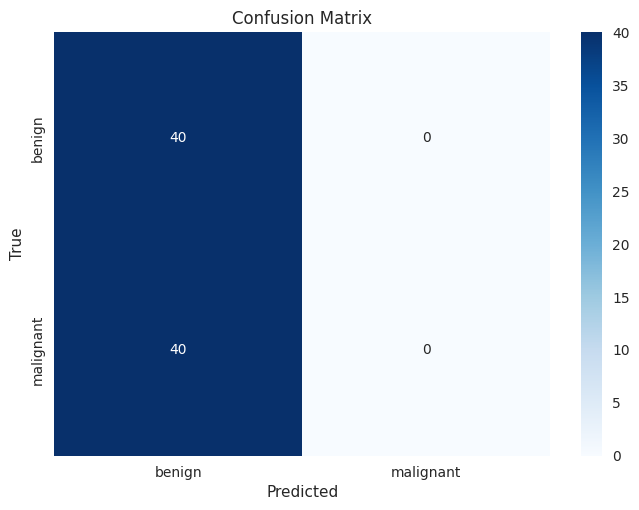

              precision    recall  f1-score   support

      benign       0.50      1.00      0.67        40
   malignant       0.00      0.00      0.00        40

    accuracy                           0.50        80
   macro avg       0.25      0.50      0.33        80
weighted avg       0.25      0.50      0.33        80



In [57]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['benign','malignant'], yticklabels=['benign','malignant'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(all_labels, all_preds, target_names=['benign', 'malignant']))
